# Kaggle入門

In [1]:
import pandas as pd
df= pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#欠損値はいくつあるか
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
# 年齢は中央値で補完
df["Age"].fillna(df["Age"].median(), inplace=True)
# 次の2つのコードでも同じように可能です。
# df["Age"].fillna(df.Age.median(), inplace=True)
# df.Age.fillna(df.Age.median(), inplace=True)

#キャビンデータセットのカテゴライズが難しいため削除
df = df.drop('Cabin',axis=1)

"""
pandasのversionが0.20.3かつPythonのバージョンが3.7系の場合以下のように
複数のカラムを削除することも可能です。
df.drop(labels=["Name", "Cabin", "Ticket"], axis=1, inplace=True)

上記コードのinplaceをTrueに指定していますが、こうすることで
df = df.drop(・・・)と変数に再代入せずにデータフレームの中身が更新されます。
"""

'\npandasのversionが0.20.3かつPythonのバージョンが3.7系の場合以下のように\n複数のカラムを削除することも可能です。\ndf.drop(labels=["Name", "Cabin", "Ticket"], axis=1, inplace=True)\n\n上記コードのinplaceをTrueに指定していますが、こうすることで\ndf = df.drop(・・・)と変数に再代入せずにデータフレームの中身が更新されます。\n'

In [4]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

# データ可視化

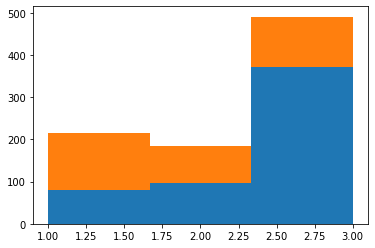

'\n# 上記matplotlibを使って複雑にコードを書いてしまっていますが、Seabornモジュールのbarplotを使うと短く実現できます。\n# https://aiacademy.jp/texts/show/?id=141\nimport seaborn as sns\ntrain = pd.read_csv("train.csv")\nsns.barplot(x=train.Sex, y=train.Survived, hue=train.Pclass )\nplt.show()\n'

In [7]:
import matplotlib.pyplot as plt
split_data = []
for survived in [0,1]:
    split_data.append(df[df.Survived==survived])

temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3)
plt.show()

"""
# 上記matplotlibを使って複雑にコードを書いてしまっていますが、Seabornモジュールのbarplotを使うと短く実現できます。
# https://aiacademy.jp/texts/show/?id=141
import seaborn as sns
train = pd.read_csv("train.csv")
sns.barplot(x=train.Sex, y=train.Survived, hue=train.Pclass )
plt.show()
"""

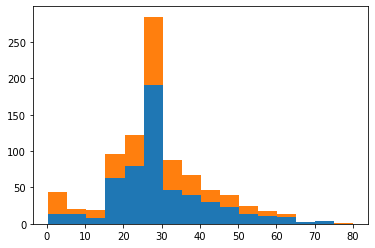

In [6]:
temp = [i["Age"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=16)
plt.show()

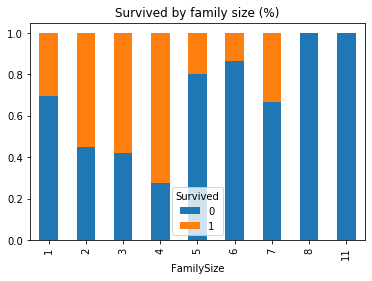

In [8]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
pd.crosstab(df['FamilySize'], df['Survived'], normalize='index').plot(
    kind='bar', stacked=True, title="Survived by family size (%)")
plt.show()

# データ整形

In [10]:
#キャビンデータセットの欠損値が多いため削除
# df = df.drop('Cabin',axis=1)

In [11]:
#性別(sex)と乗船場所(enmark)のデータはダミー変数を作成する
#まずはsexから、性別のdummy変数を作成する
sex_dum = pd.get_dummies(df['Sex'])
#データの連結をする
df = pd.concat((df,sex_dum),axis=1)
#データからsexの列を取り除く
df = df.drop('Sex',axis=1)
#性別は男か女かのみなので男なら1というデータのみあればよい
df = df.drop('female',axis=1)

#乗船場所でも同様
emb_dum = pd.get_dummies(df['Embarked'])
df = pd.concat((df,emb_dum),axis=1)
df = df.drop('Embarked',axis=1)
df = df.drop('S',axis=1)

In [12]:
#明らかにいらないデータの削除
df = df.drop('Name',axis=1)
df = df.drop('Ticket',axis=1)

In [13]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,male,C,Q
0,1,0,3,22.0,1,0,7.2500,2,1,0,0
1,2,1,1,38.0,1,0,71.2833,2,0,1,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0
3,4,1,1,35.0,1,0,53.1000,2,0,0,0
4,5,0,3,35.0,0,0,8.0500,1,1,0,0


# ランダムフォレストを用いた学習

In [14]:
#データを二つに分離
train_data = df.values
x = train_data[:, 2:] # Pclass以降の変数
y  = train_data[:, 1]  # 正解データ（Survivedの列）

#必要なパッケージのインポート
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)

# 学習する
forest = forest.fit(x, y)

In [15]:
test_df = pd.read_csv("test.csv")
# テストデータの欠損値の補完
#まずはsexから、性別のdummy変数を作成する
sex_dum = pd.get_dummies(test_df['Sex'])
#データの連結をする
test_df = pd.concat((test_df,sex_dum),axis=1)
#データからsexの列を取り除く
test_df = test_df.drop('Sex',axis=1)
#性別は男か女かのみなので男なら1というデータのみあればよい
test_df = test_df.drop('female',axis=1)

#乗船場所でも同様
emb_dum = pd.get_dummies(test_df['Embarked'])
test_df = pd.concat((test_df,emb_dum),axis=1)
test_df = test_df.drop('Embarked',axis=1)
test_df = test_df.drop('S',axis=1)

#家族の多さを加える
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

#明らかにいらないデータや欠損値の多いデータは削除する
test_df = test_df.drop('Name',axis=1)
test_df = test_df.drop('Ticket',axis=1)
test_df = test_df.drop('Cabin',axis=1)

#年齢は中央値で補完
test_df["Age"].fillna(test_df.Age.median(), inplace=True)

test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,C,Q,FamilySize
0,892,3,34.5,0,0,7.8292,1,0,1,1
1,893,3,47.0,1,0,7.0000,0,0,0,2
2,894,2,62.0,0,0,9.6875,1,0,1,1
3,895,3,27.0,0,0,8.6625,1,0,0,1
4,896,3,22.0,1,1,12.2875,0,0,0,3


In [16]:
#欠損値はいくつあるか
test_df.isnull().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           1
male           0
C              0
Q              0
FamilySize     0
dtype: int64

In [17]:
# 料金は中央値で補完
test_df["Fare"].fillna(test_df.Fare.median(), inplace=True)

In [18]:
test_data = test_df.values
x_test = test_data[:, 1:] # この行でエラーが出たら次の行に変更してください
# x_test = test_data[:, 2:]
output = forest.predict(x_test)

# zip_data = zip(test_data[:,0], output)
# redict_data = list(zip_data)

# 提出できる形式にする

In [19]:
import csv
with open("submission.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_data[:,0].astype(int), output.astype(int)):
        writer.writerow([pid, survived])